# Setup Yolo-V5

In [1]:
!git clone https://github.com/ultralytics/yolov5.git
%cd yolov5

Cloning into 'yolov5'...
remote: Enumerating objects: 17265, done.
remote: Counting objects: 100% (92/92), done.
remote: Compressing objects: 100% (82/82), done.
remote: Total 17265 (delta 46), reused 10 (delta 10), pack-reused 17173 (from 5)
Receiving objects: 100% (17265/17265), 16.00 MiB | 13.38 MiB/s, done.
Resolving deltas: 100% (11791/11791), done.
/content/yolov5


In [2]:
!pip install -qr requirements.txt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 910.1/910.1 kB 14.9 MB/s eta 0:00:00


In [3]:
import torch
from IPython.display import Image, clear_output

print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

Setup complete. Using torch 2.5.1+cu121 _CudaDeviceProperties(name='Tesla T4', major=7, minor=5, total_memory=15102MB, multi_processor_count=40, uuid=ed5de0fe-1bbd-fb10-4c8d-4b8e76719ff9, L2_cache_size=4MB)


# Custom dataset

In [4]:
%cd /content

/content


In [5]:
import gdown

url = "https://drive.google.com/file/d/1ECfl3dtYyfivY8kYPq7RHUBTjC-2vf61/view?usp=share_link"

prefix = 'https://drive.google.com/uc?/export=download&id='
file_id = url.split("/")[-2]
print(f'file id: {file_id}')

gdown.download(prefix+file_id)
print("Data downloaded!")

file id: 1ECfl3dtYyfivY8kYPq7RHUBTjC-2vf61


Downloading...
From (original): https://drive.google.com/uc?/export=download&id=1ECfl3dtYyfivY8kYPq7RHUBTjC-2vf61
From (redirected): https://drive.google.com/uc?%2Fexport=download&id=1ECfl3dtYyfivY8kYPq7RHUBTjC-2vf61&confirm=t&uuid=0d8adb4f-fa9e-48fa-902f-57c3be6668f2
To: /content/waste-detection.zip
100%|██████████| 40.1M/40.1M [00:01<00:00, 32.3MB/s]

Data downloaded!


In [6]:
!unzip waste-detection.zip
!rm -rf waste-detection.zip

Archive:  waste-detection.zip
  inflating: data.yaml               
   creating: train/
   creating: train/images/
  inflating: train/images/Banana_10_jpg.rf.7c0536bc9eb72ec77c8f515653f44fb9.jpg  
  inflating: train/images/Banana_11_jpg.rf.188551ec3d51326e5562675d285d0e6a.jpg  
  inflating: train/images/Banana_12_jpg.rf.2ecabc9628a9611963e4804d13045377.jpg  
  inflating: train/images/Banana_12_jpg.rf.e951f9b4b66c9896ce6b7a56f9d41438.jpg  
  inflating: train/images/Banana_15_jpg.rf.09c5d34e95e0c06a808a99533e8e737c.jpg  
  inflating: train/images/Banana_15_jpg.rf.c2909c26fa3140f1734b451bead6752b.jpg  
  inflating: train/images/Banana_15_jpg.rf.e7fb3723604fb753bdbca26f382d7aaf.jpg  
  inflating: train/images/Banana_16_jpg.rf.504aa1c1679f9d595e336eba25f6d80c.jpg  
  inflating: train/images/Banana_16_jpg.rf.73833169c2979508c979f27bcb572959.jpg  
  inflating: train/images/Banana_16_jpg.rf.bd09b3cf6ae33d668a421a48b8c4b34b.jpg  
  inflating: train/images/Banana_16_jpg.rf.dbfad378a52e84709bbb24

In [7]:
%cat data.yaml

train: ../train/images
val: ../valid/images


nc: 13
names: ['banana', 'chilli', 'drinkcan', 'drinkpack', 'foodcan', 'lettuce', 'paperbag', 'plasticbag', 'plasticbottle', 'plasticcontainer', 'sweetpotato', 'teabag', 'tissueroll']



# Define Model Configuration and Architecture

In [8]:
import yaml

with open('data.yaml', 'r') as stream:
  num_classes = str(yaml.safe_load(stream)['nc'])
num_classes

'13'

In [9]:
%cat /content/yolov5/models/yolov5s.yaml

# Ultralytics 🚀 AGPL-3.0 License - https://ultralytics.com/license

# Parameters
nc: 80 # number of classes
depth_multiple: 0.33 # model depth multiple
width_multiple: 0.50 # layer channel multiple
anchors:
  - [10, 13, 16, 30, 33, 23] # P3/8
  - [30, 61, 62, 45, 59, 119] # P4/16
  - [116, 90, 156, 198, 373, 326] # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [
    [-1, 1, Conv, [64, 6, 2, 2]], # 0-P1/2
    [-1, 1, Conv, [128, 3, 2]], # 1-P2/4
    [-1, 3, C3, [128]],
    [-1, 1, Conv, [256, 3, 2]], # 3-P3/8
    [-1, 6, C3, [256]],
    [-1, 1, Conv, [512, 3, 2]], # 5-P4/16
    [-1, 9, C3, [512]],
    [-1, 1, Conv, [1024, 3, 2]], # 7-P5/32
    [-1, 3, C3, [1024]],
    [-1, 1, SPPF, [1024, 5]], # 9
  ]

# YOLOv5 v6.0 head
head: [
    [-1, 1, Conv, [512, 1, 1]],
    [-1, 1, nn.Upsample, [None, 2, "nearest"]],
    [[-1, 6], 1, Concat, [1]], # cat backbone P4
    [-1, 3, C3, [512, False]], # 13

    [-1, 1, Conv, [256, 1, 1]],
    [-1, 1, nn.Upsample, [None, 2, 

but we have 13 class in our custom dataset, so lets change the number of classes in yolov5 model

In [10]:
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
  with open(line, 'w') as f:
    f.write(cell.format(**globals()))

In [11]:
%%writetemplate /content/yolov5/models/custom_yolov5s.yaml

# Parameters
nc: {num_classes} # number of classes
depth_multiple: 0.33 # model depth multiple
width_multiple: 0.50 # layer channel multiple
anchors:
  - [10, 13, 16, 30, 33, 23] # P3/8
  - [30, 61, 62, 45, 59, 119] # P4/16
  - [116, 90, 156, 198, 373, 326] # P5/32

# YOLOv5 v6.0 backbone
backbone:
  # [from, number, module, args]
  [
    [-1, 1, Conv, [64, 6, 2, 2]], # 0-P1/2
    [-1, 1, Conv, [128, 3, 2]], # 1-P2/4
    [-1, 3, C3, [128]],
    [-1, 1, Conv, [256, 3, 2]], # 3-P3/8
    [-1, 6, C3, [256]],
    [-1, 1, Conv, [512, 3, 2]], # 5-P4/16
    [-1, 9, C3, [512]],
    [-1, 1, Conv, [1024, 3, 2]], # 7-P5/32
    [-1, 3, C3, [1024]],
    [-1, 1, SPPF, [1024, 5]], # 9
  ]

# YOLOv5 v6.0 head
head: [
    [-1, 1, Conv, [512, 1, 1]],
    [-1, 1, nn.Upsample, [None, 2, "nearest"]],
    [[-1, 6], 1, Concat, [1]], # cat backbone P4
    [-1, 3, C3, [512, False]], # 13

    [-1, 1, Conv, [256, 1, 1]],
    [-1, 1, nn.Upsample, [None, 2, "nearest"]],
    [[-1, 4], 1, Concat, [1]], # cat backbone P3
    [-1, 3, C3, [256, False]], # 17 (P3/8-small)

    [-1, 1, Conv, [256, 3, 2]],
    [[-1, 14], 1, Concat, [1]], # cat head P4
    [-1, 3, C3, [512, False]], # 20 (P4/16-medium)

    [-1, 1, Conv, [512, 3, 2]],
    [[-1, 10], 1, Concat, [1]], # cat head P5
    [-1, 3, C3, [1024, False]], # 23 (P5/32-large)

    [[17, 20, 23], 1, Detect, [nc, anchors]], # Detect(P3, P4, P5)
  ]

# Train custom yolo v5 detector

In [12]:
%%time
%cd /content/yolov5
!python train.py --img 416 --batch 16 --epochs 50 --data '../data.yaml' --cfg ./models/custom_yolov5s.yaml --weights 'yolov5s.pt' --name yolov5s_results --cache

Streaming output truncated to the last 5000 lines.
       8/49      1.96G    0.03537    0.01524    0.03869         47        416:  91% 53/58 [00:12<00:00,  5.51it/s]/content/yolov5/train.py:412: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(amp):
       8/49      1.96G    0.03544     0.0153     0.0387         65        416:  93% 54/58 [00:12<00:00,  5.72it/s]/content/yolov5/train.py:412: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(amp):
       8/49      1.96G    0.03541    0.01527    0.03859         50        416:  95% 55/58 [00:13<00:00,  6.09it/s]/content/yolov5/train.py:412: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(amp):
       8/49      1.96G    0.03536    

In [13]:
%load_ext tensorboard
tensorboard -logdir runs

SyntaxError: invalid syntax (<ipython-input-13-de7870565b9c>, line 2)

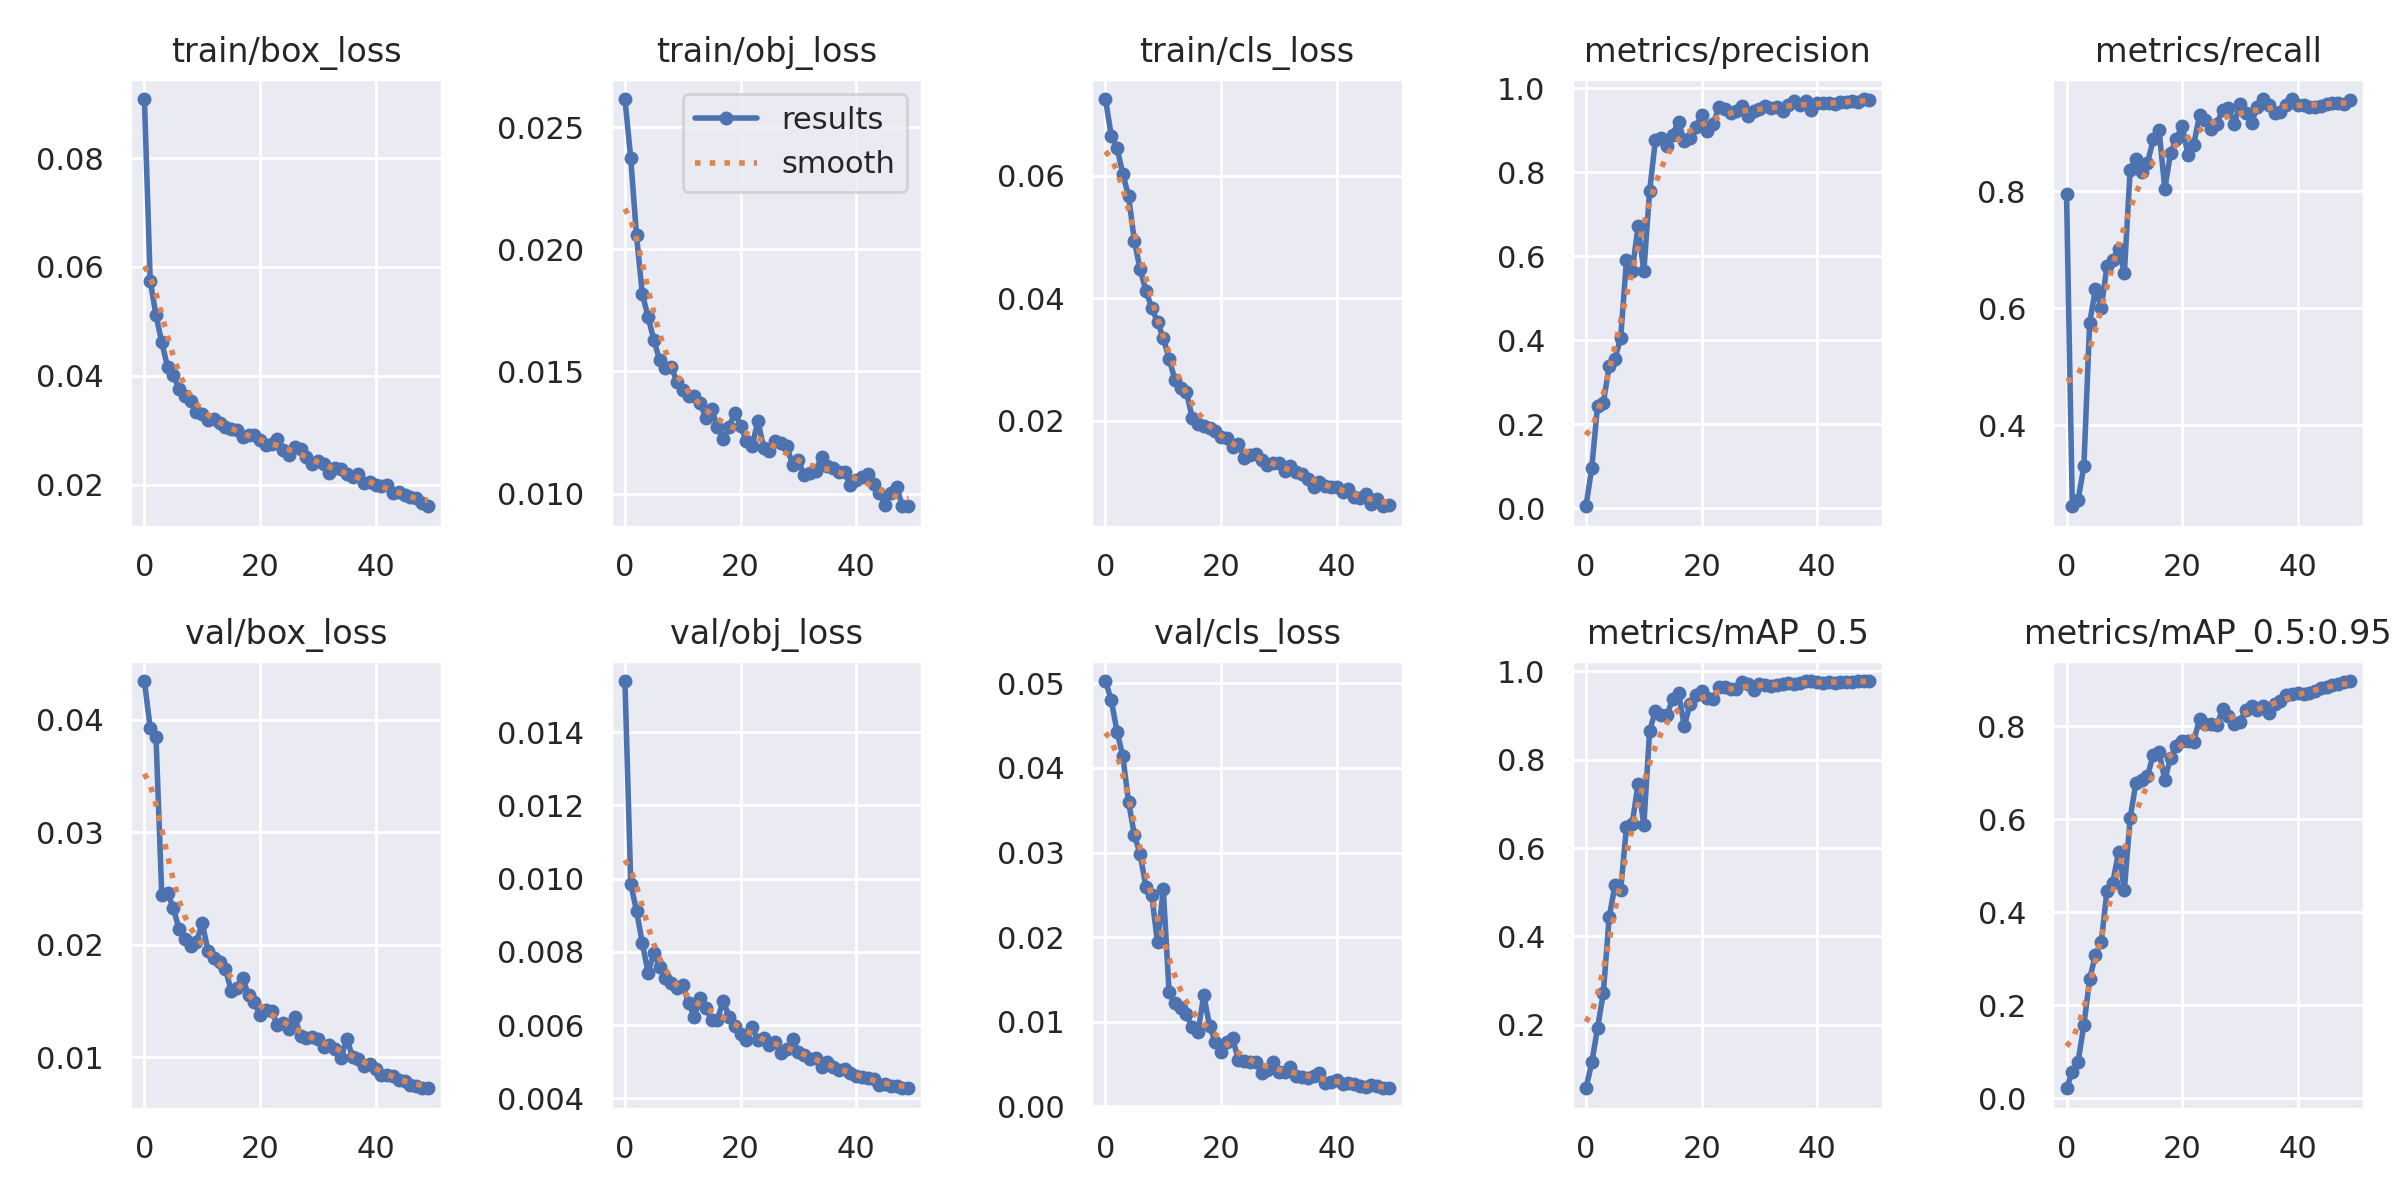

In [15]:
from utils.plots import plot_results
Image(filename='/content/yolov5/runs/train/yolov5s_results/results.png', width=1000)

Ground Truth training data:


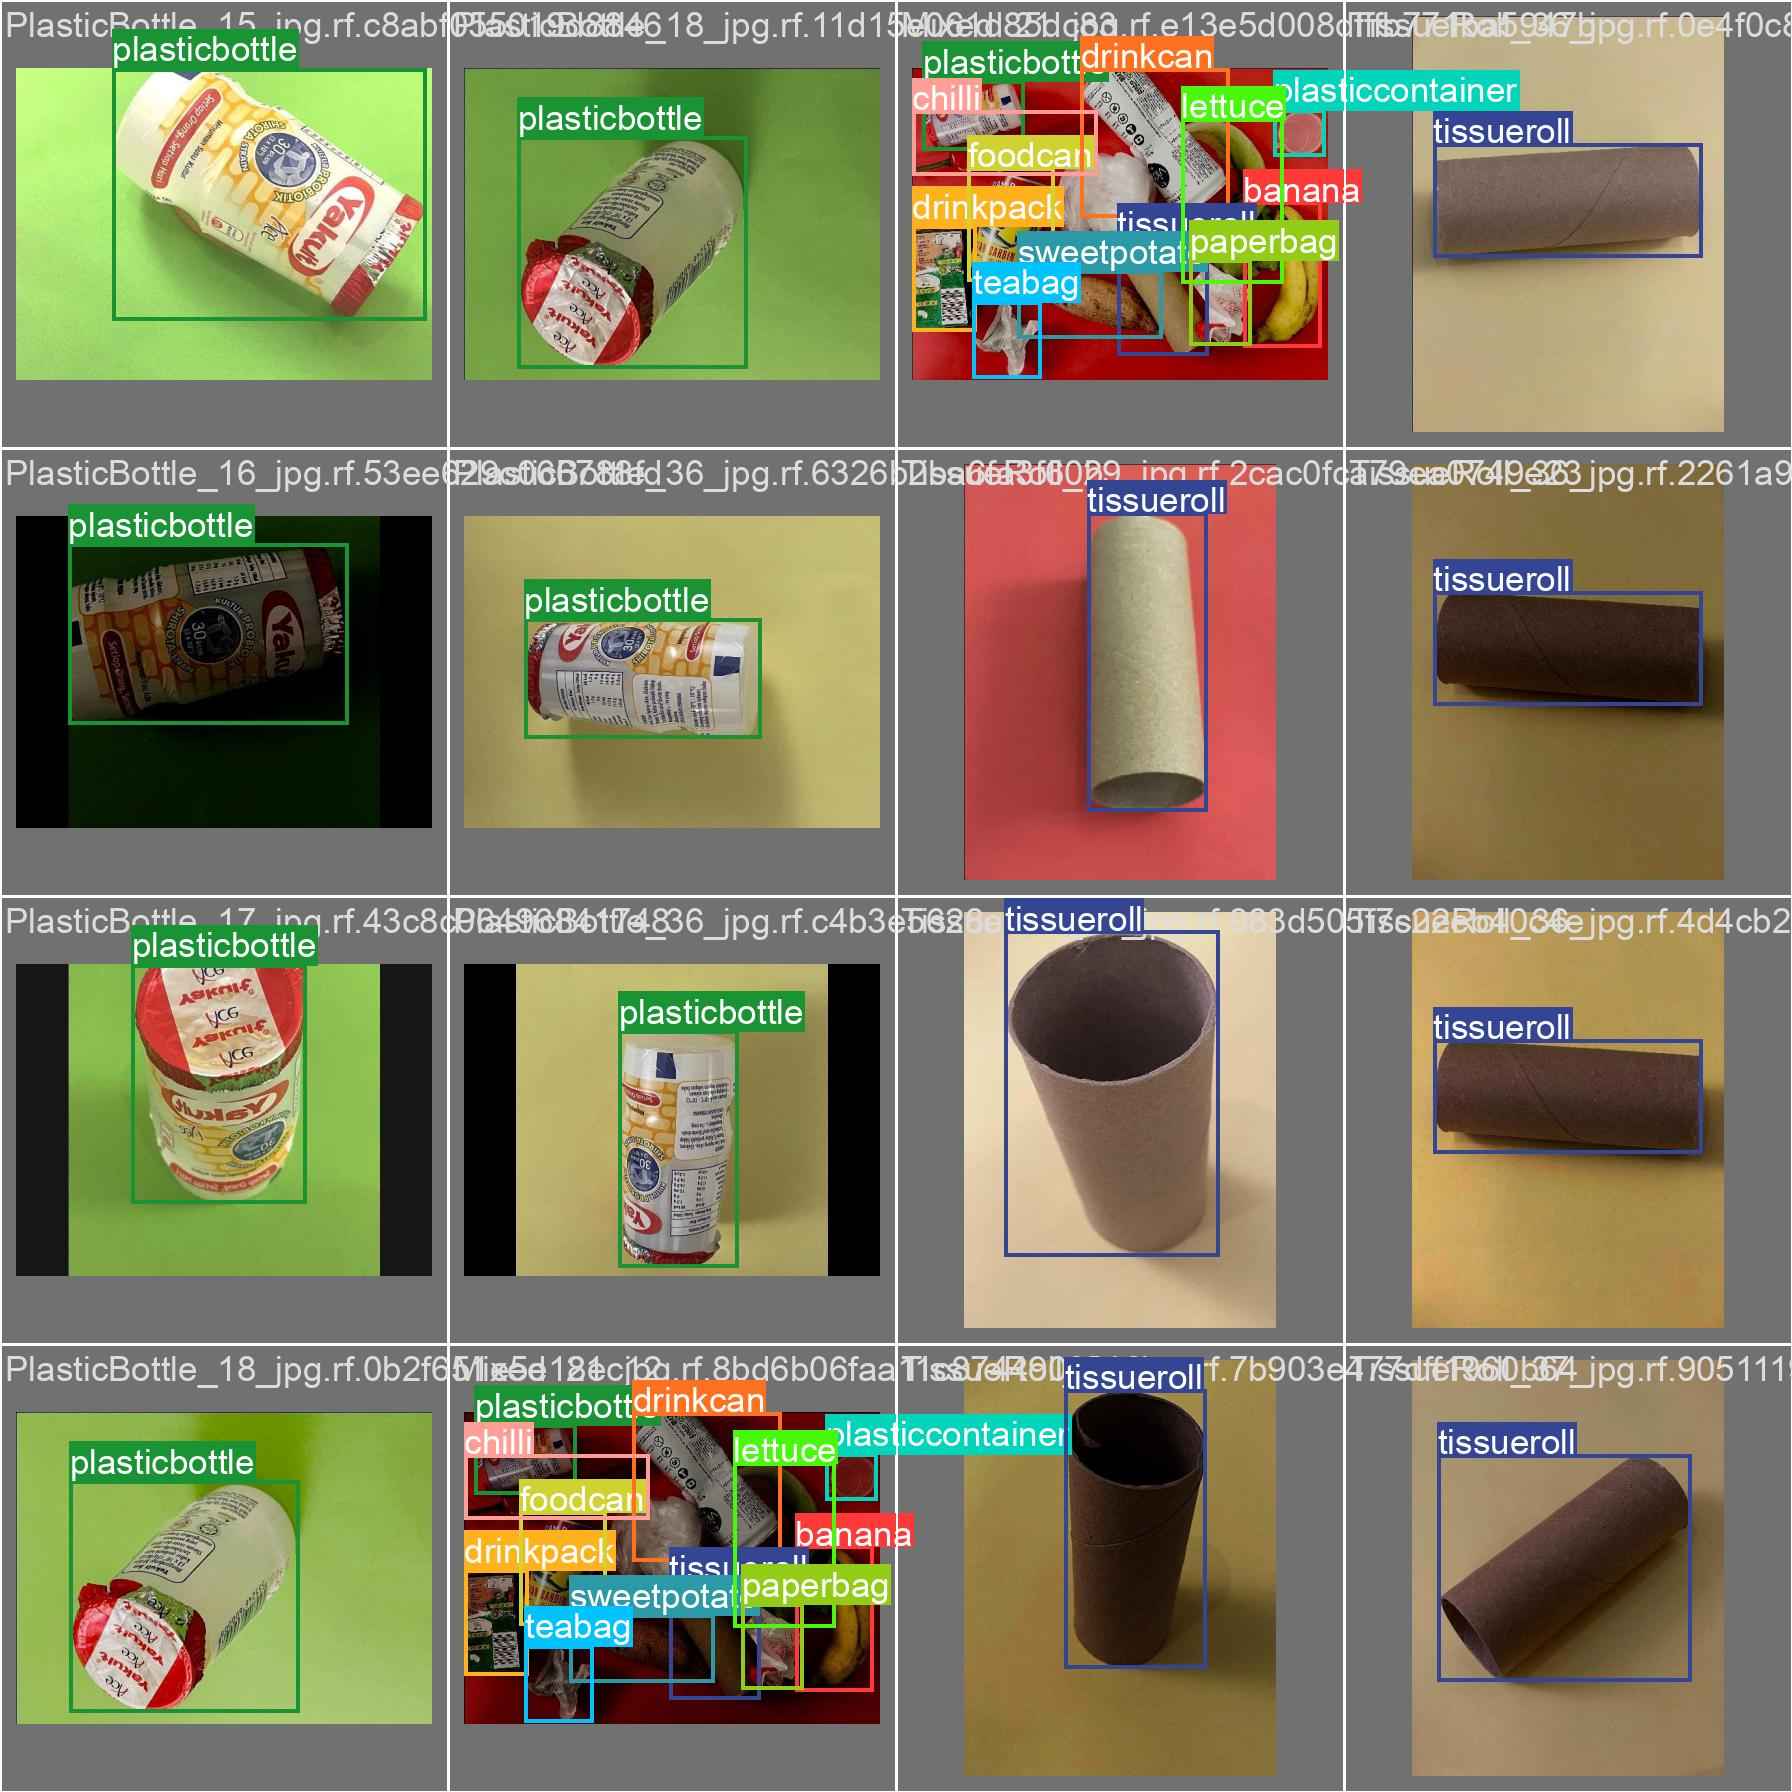

In [17]:
print('Ground Truth training data:')
Image(filename='/content/yolov5/runs/train/yolov5s_results/val_batch0_labels.jpg', width=1000)

Ground Truth augmented training data:


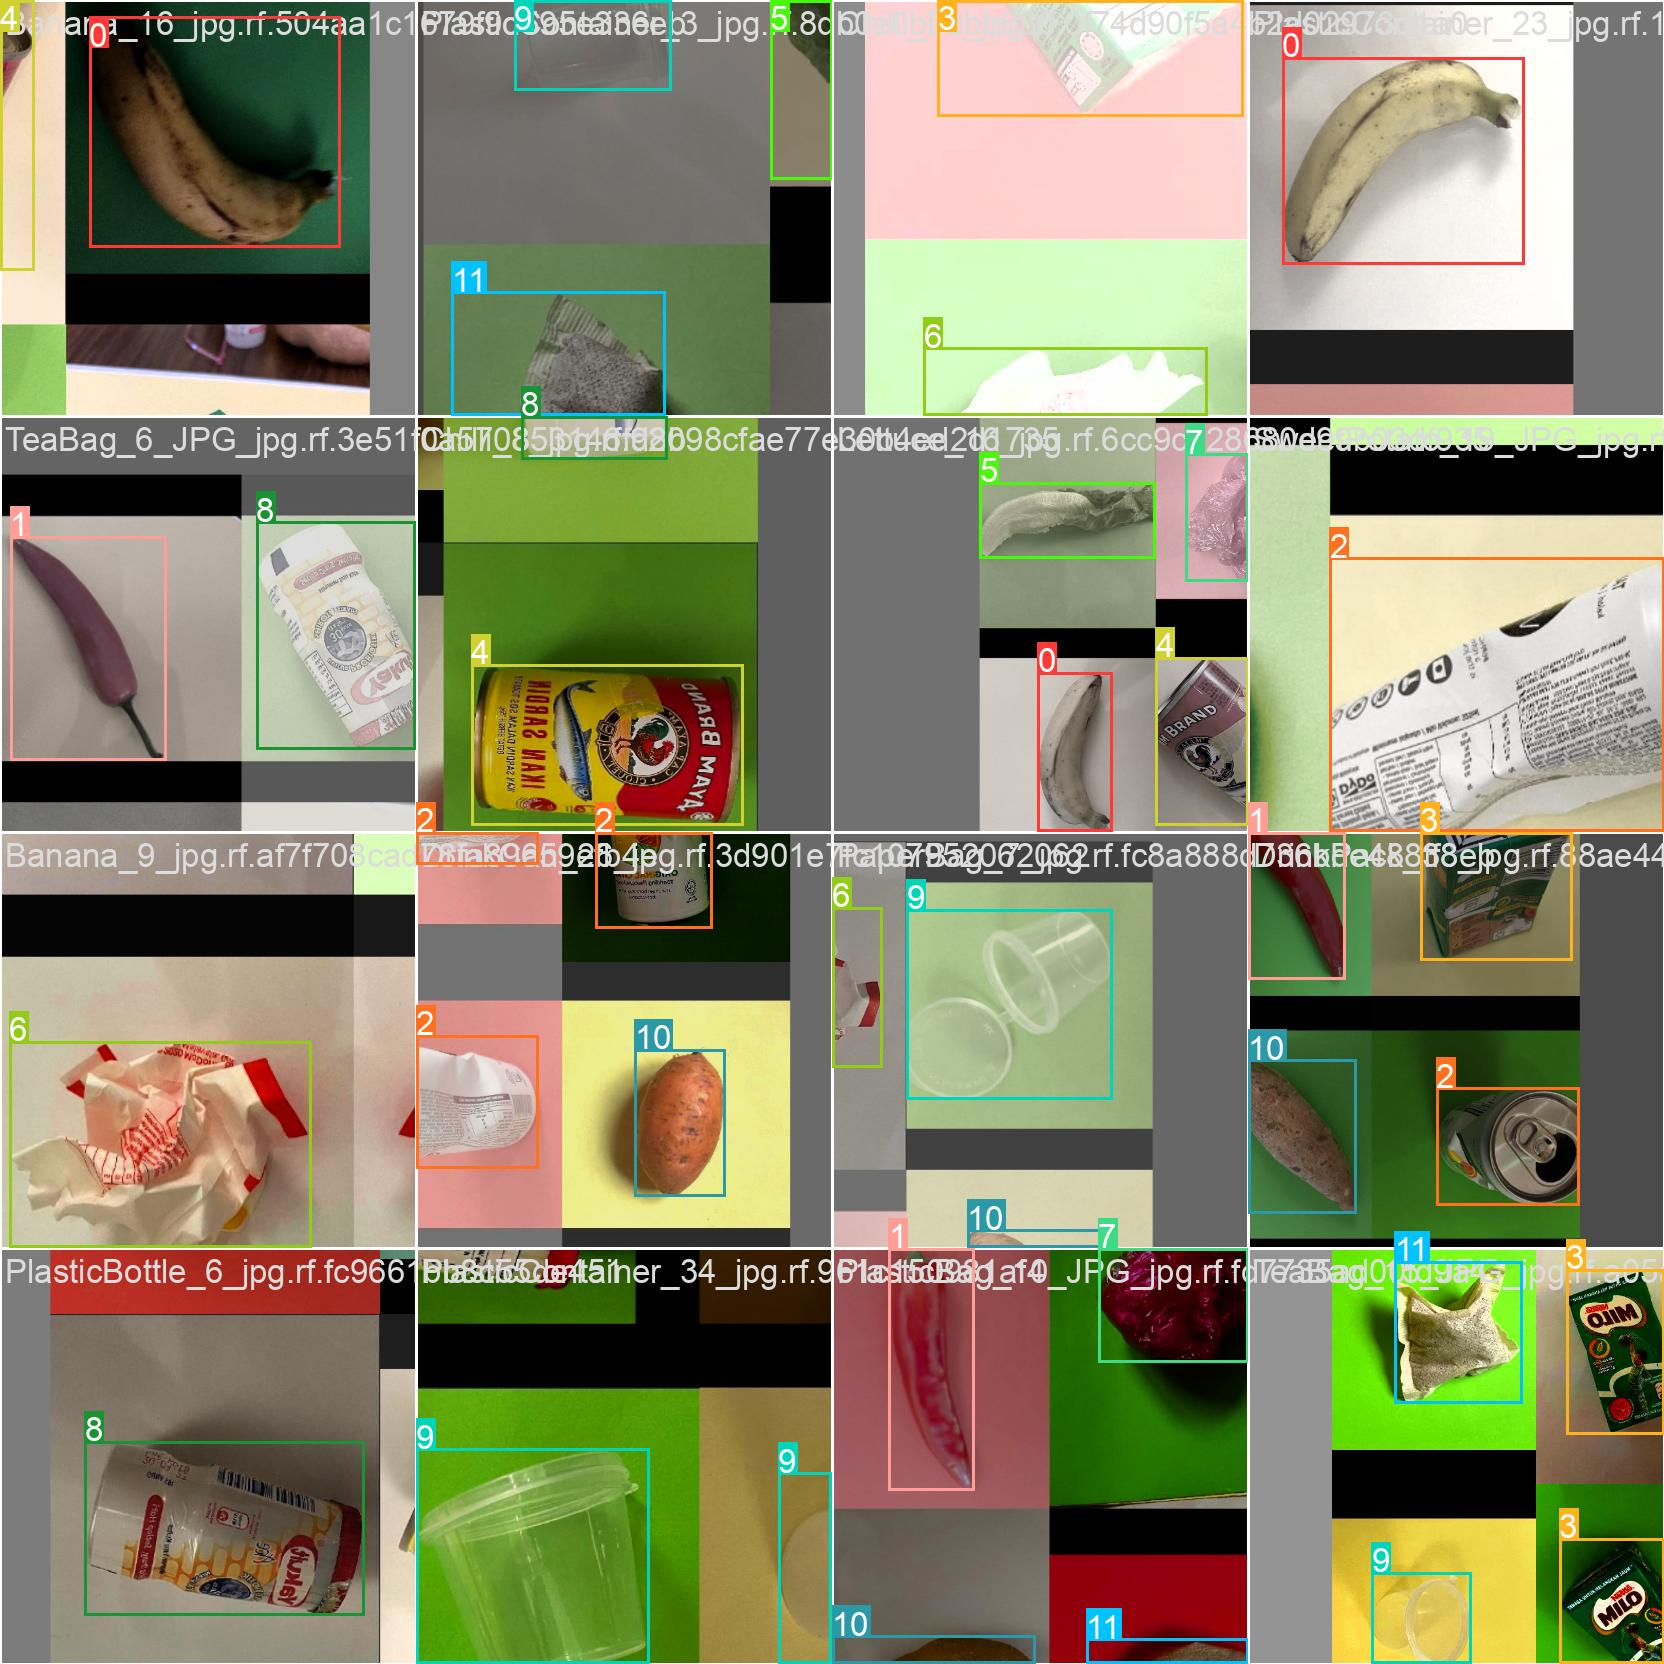

In [20]:
print('Ground Truth augmented training data:')
Image(filename='/content/yolov5/runs/train/yolov5s_results/train_batch0.jpg', width=1000)

In [22]:
%ls /content/yolov5/runs/train/yolov5s_results/weights

best.pt  last.pt


In [25]:
%cd /content/yolov5
!python detect.py --weights runs/train/yolov5s_results/weights/best.pt --img 416 --conf 0.5 --source ../valid/images

/content/yolov5
detect: weights=['runs/train/yolov5s_results/weights/best.pt'], source=../valid/images, data=data/coco128.yaml, imgsz=[416, 416], conf_thres=0.5, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=False, save_format=0, save_csv=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False, vid_stride=1
YOLOv5 🚀 v7.0-397-gde62f93c Python-3.11.11 torch-2.5.1+cu121 CUDA:0 (Tesla T4, 15102MiB)

Fusing layers... 
custom_YOLOv5s summary: 157 layers, 7045186 parameters, 0 gradients, 15.9 GFLOPs
WARNING ⚠️ NMS time limit 0.550s exceeded
image 1/459 /content/valid/images/Banana_10_jpg.rf.0f4f5f5b749f5681048000d59b667d94.jpg: 416x320 1 banana, 44.7ms
image 2/459 /content/valid/images/Banana_10_jpg.rf.5d587c81371bd16a3a5eba3af30ce089.jpg: 416x320 1 banana, 6.8ms
image 3/459 /

# Export trained weights for future inference

mount drive first ..

In [29]:
%cp /content/yolov5/runs/train/yolov5s_results/weights/best.pt /content/drive/MyDrive/custom_yolov5

Congrats!